# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

A subdirectory or file data already exists.


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

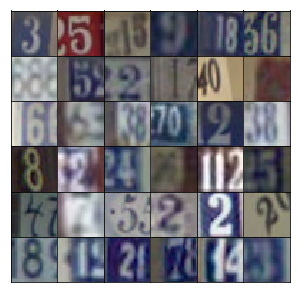

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
kernel = np.zeros([7,7,1,1])
for i in range(7):
    for j in range(7):
        kernel[i,j,0,0] = np.exp(-(i*i+j*j)/8)

def get_static_slice(x, ind, batch_size):
    # gets one channel, preseving other dimensions
    x_shape = x.get_shape().as_list()
    slice_shape =  tf.stack([batch_size, x_shape[1], x_shape[2],1])
    return tf.slice(x,[0,0,0,ind],slice_shape)

def generate_multiscale(x, prev_out, output_dim, batch_size):
    x_shape = x.get_shape().as_list()
    deconv_shape = tf.stack([batch_size, 2*x_shape[1], 2*x_shape[2],1])
    #slice_shape =  tf.stack([batch_size, x_shape[1], x_shape[2],1])
    ker = tf.constant(kernel, tf.float32)
    channels =[]
    for i in range(3):
        weights =get_static_slice(x,i, batch_size) #tf.slice(x,[0,0,0,i],slice_shape)
        #print(weights.get_shape().as_list())
        if prev_out is not None:
            weights = weights + get_static_slice(prev_out,i, batch_size) #tf.slice(prev_out,[0,0,0,i],slice_shape)
            
        y = tf.nn.conv2d_transpose(weights,ker,deconv_shape, strides=[1,2,2,1])
        channels.append(y)
    out = tf.concat(channels,3)
    #print(tf.shape(out))
    return out

def generator(z, output_dim, batch_size, reuse=False, alpha=0.2, training=True):
    init_dim =[-1,4,4,512]
    init_len = 4*4*512
    filters = 512
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z,init_len)
        x = tf.reshape(x, tf.cast(init_dim, tf.int32))
        x = tf.layers.batch_normalization(x, training = training)
        # before relu as want to also allow negative values
        out = generate_multiscale(x, None, output_dim, batch_size) # out_dims are 8,16, 32
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)

        # so now we're at 4x4x512
        for i in range(3):
            #             print(out.get_shape().as_list())
#             print(x.get_shape().as_list())
            if i<2:
                filters = filters/2
            else:
                filters = output_dim
                
            x = tf.layers.conv2d_transpose(inputs = x, 
                                           filters = int(filters), 
                                           kernel_size =5,
                                           strides = 2,
                                           padding = 'same')
            
            if i < 2:
                # include 'out' in batch norm
                x = tf.concat([x,out],3)
                x = tf.layers.batch_normalization(x, training = training)
                # extract 'out' again
                x_channels = x.get_shape().as_list()[-1]
                #print(x_channels)
                tmp = []
                for j in range(3):
                    tmp.append(get_static_slice(x,x_channels-1+j, batch_size))
                
                out = tf.concat(out,3)
                # before relu as want to also allow negative values
                out = generate_multiscale(x, out, output_dim, batch_size) # out_dims are 8,16, 32
                x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        
        # Output layer, 32x32x3
        logits = x + out
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        filters = 64
        # Input layer is 32x32x3
        for i in range(3):
            x = tf.layers.conv2d(inputs = x, 
                                 filters = filters, 
                                 kernel_size = 5, 
                                 strides = 2,
                                 padding="same")
            x = tf.layers.batch_normalization(x, training = True)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            filters = 2*filters
        
        flat = tf.contrib.layers.flatten(x)
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, batch_size, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, batch_size, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, batch_size, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], batch_size, alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, sample_z.shape[0], reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 20
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, batch_size, alpha=alpha, beta1=beta1)

Epoch 1/20... Discriminator Loss: 0.6674... Generator Loss: 1.5089
Epoch 1/20... Discriminator Loss: 0.3987... Generator Loss: 2.2932
Epoch 1/20... Discriminator Loss: 0.1991... Generator Loss: 2.5373
Epoch 1/20... Discriminator Loss: 0.3545... Generator Loss: 2.9414
Epoch 1/20... Discriminator Loss: 0.5580... Generator Loss: 1.9036
Epoch 1/20... Discriminator Loss: 0.2962... Generator Loss: 2.7453
Epoch 1/20... Discriminator Loss: 0.1903... Generator Loss: 2.7837
Epoch 1/20... Discriminator Loss: 0.3386... Generator Loss: 1.7652
Epoch 1/20... Discriminator Loss: 0.1483... Generator Loss: 2.6863
Epoch 1/20... Discriminator Loss: 0.1593... Generator Loss: 2.6949


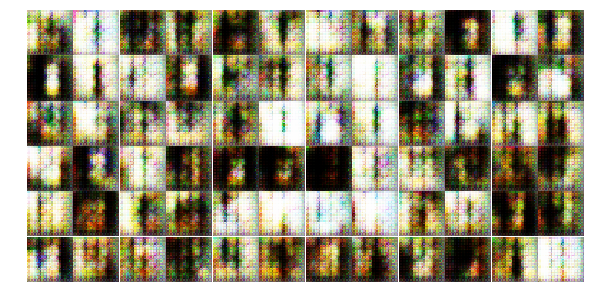

Epoch 1/20... Discriminator Loss: 0.0773... Generator Loss: 3.2906
Epoch 1/20... Discriminator Loss: 0.2221... Generator Loss: 2.5780
Epoch 1/20... Discriminator Loss: 0.2098... Generator Loss: 3.2274
Epoch 1/20... Discriminator Loss: 0.0771... Generator Loss: 3.9334
Epoch 1/20... Discriminator Loss: 0.2475... Generator Loss: 2.0747
Epoch 1/20... Discriminator Loss: 0.0984... Generator Loss: 2.9782
Epoch 1/20... Discriminator Loss: 0.0665... Generator Loss: 3.2369
Epoch 1/20... Discriminator Loss: 0.1302... Generator Loss: 2.8247
Epoch 1/20... Discriminator Loss: 0.2716... Generator Loss: 1.7266
Epoch 1/20... Discriminator Loss: 0.9683... Generator Loss: 6.3197


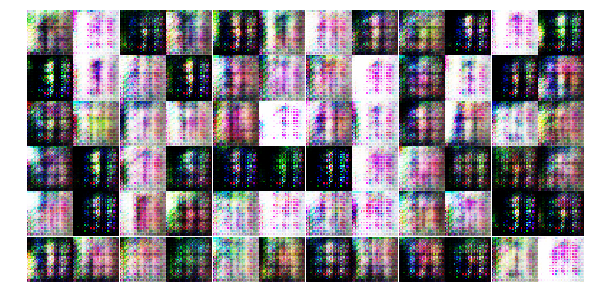

Epoch 1/20... Discriminator Loss: 0.5365... Generator Loss: 1.2468
Epoch 1/20... Discriminator Loss: 0.2131... Generator Loss: 2.5367
Epoch 1/20... Discriminator Loss: 0.2710... Generator Loss: 2.2161
Epoch 1/20... Discriminator Loss: 0.0888... Generator Loss: 3.2290
Epoch 1/20... Discriminator Loss: 0.0890... Generator Loss: 3.2251
Epoch 1/20... Discriminator Loss: 0.1064... Generator Loss: 3.4339
Epoch 1/20... Discriminator Loss: 0.0970... Generator Loss: 3.2113
Epoch 1/20... Discriminator Loss: 0.1254... Generator Loss: 2.4886
Epoch 1/20... Discriminator Loss: 0.3426... Generator Loss: 3.4059
Epoch 1/20... Discriminator Loss: 0.0818... Generator Loss: 3.7372


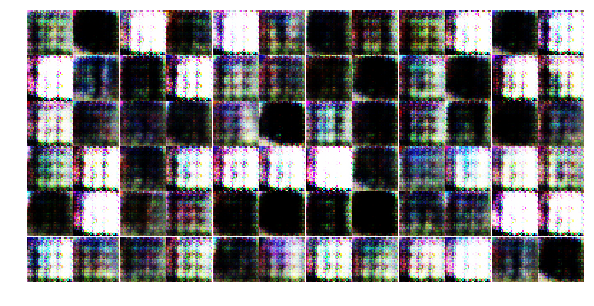

Epoch 1/20... Discriminator Loss: 0.2905... Generator Loss: 1.8564
Epoch 1/20... Discriminator Loss: 0.1291... Generator Loss: 2.8534
Epoch 1/20... Discriminator Loss: 0.3743... Generator Loss: 1.8008
Epoch 1/20... Discriminator Loss: 0.2526... Generator Loss: 3.4314
Epoch 1/20... Discriminator Loss: 0.3264... Generator Loss: 1.9974
Epoch 1/20... Discriminator Loss: 0.0598... Generator Loss: 4.3836
Epoch 1/20... Discriminator Loss: 0.6849... Generator Loss: 1.1520
Epoch 1/20... Discriminator Loss: 0.1836... Generator Loss: 2.7328
Epoch 1/20... Discriminator Loss: 0.1899... Generator Loss: 3.9153
Epoch 1/20... Discriminator Loss: 0.3088... Generator Loss: 1.8100


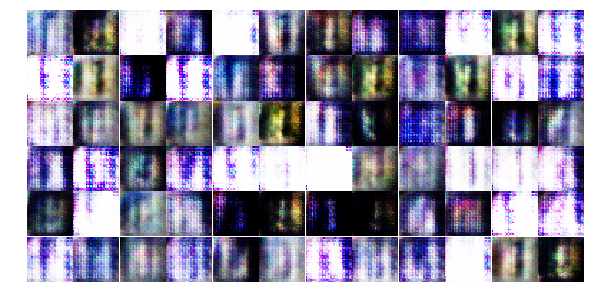

Epoch 1/20... Discriminator Loss: 0.3450... Generator Loss: 2.2038
Epoch 1/20... Discriminator Loss: 0.1101... Generator Loss: 3.7549
Epoch 1/20... Discriminator Loss: 0.4749... Generator Loss: 2.5673
Epoch 1/20... Discriminator Loss: 0.0580... Generator Loss: 4.7634
Epoch 1/20... Discriminator Loss: 0.8261... Generator Loss: 8.2544
Epoch 1/20... Discriminator Loss: 0.8972... Generator Loss: 5.9184
Epoch 1/20... Discriminator Loss: 0.2312... Generator Loss: 2.4123
Epoch 1/20... Discriminator Loss: 0.1392... Generator Loss: 2.7811
Epoch 1/20... Discriminator Loss: 0.0966... Generator Loss: 3.1729
Epoch 1/20... Discriminator Loss: 0.1109... Generator Loss: 2.8857


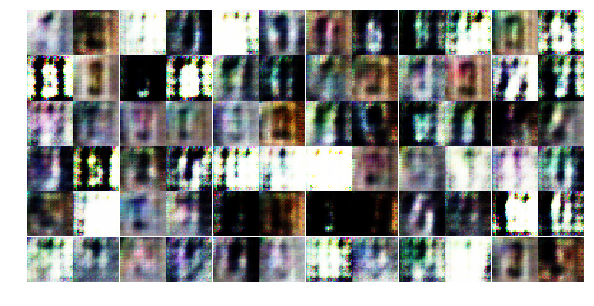

Epoch 1/20... Discriminator Loss: 0.1630... Generator Loss: 2.4901
Epoch 1/20... Discriminator Loss: 0.0425... Generator Loss: 7.1863
Epoch 1/20... Discriminator Loss: 5.5260... Generator Loss: 0.0141
Epoch 1/20... Discriminator Loss: 0.4524... Generator Loss: 2.5918
Epoch 1/20... Discriminator Loss: 0.3348... Generator Loss: 1.9886
Epoch 1/20... Discriminator Loss: 0.0693... Generator Loss: 5.3497
Epoch 1/20... Discriminator Loss: 0.1362... Generator Loss: 4.5615
Epoch 2/20... Discriminator Loss: 0.5727... Generator Loss: 1.5325
Epoch 2/20... Discriminator Loss: 0.1985... Generator Loss: 2.4958
Epoch 2/20... Discriminator Loss: 0.0727... Generator Loss: 3.4194


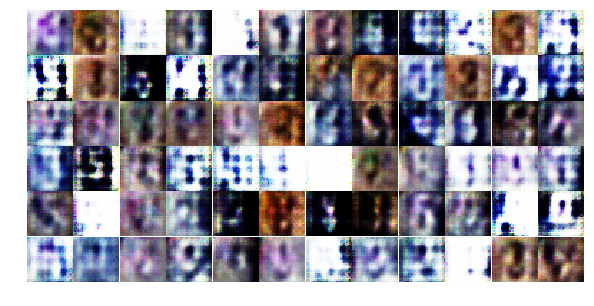

Epoch 2/20... Discriminator Loss: 0.6499... Generator Loss: 2.0220
Epoch 2/20... Discriminator Loss: 0.7057... Generator Loss: 4.8264
Epoch 2/20... Discriminator Loss: 1.8867... Generator Loss: 4.0540
Epoch 2/20... Discriminator Loss: 0.2403... Generator Loss: 2.2711
Epoch 2/20... Discriminator Loss: 0.1282... Generator Loss: 3.0189
Epoch 2/20... Discriminator Loss: 0.0563... Generator Loss: 4.6462
Epoch 2/20... Discriminator Loss: 0.1417... Generator Loss: 2.7793
Epoch 2/20... Discriminator Loss: 0.0249... Generator Loss: 5.3017
Epoch 2/20... Discriminator Loss: 0.3415... Generator Loss: 2.2741
Epoch 2/20... Discriminator Loss: 0.5035... Generator Loss: 1.5063


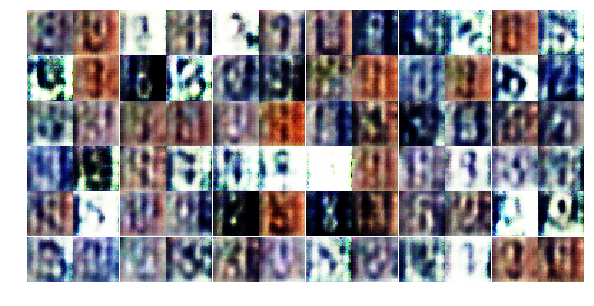

Epoch 2/20... Discriminator Loss: 0.2637... Generator Loss: 4.0372
Epoch 2/20... Discriminator Loss: 0.1861... Generator Loss: 2.5771
Epoch 2/20... Discriminator Loss: 0.1486... Generator Loss: 3.9248
Epoch 2/20... Discriminator Loss: 0.2590... Generator Loss: 4.6811
Epoch 2/20... Discriminator Loss: 0.0273... Generator Loss: 5.2768
Epoch 2/20... Discriminator Loss: 0.4408... Generator Loss: 1.3485
Epoch 2/20... Discriminator Loss: 0.1312... Generator Loss: 2.5594
Epoch 2/20... Discriminator Loss: 0.1031... Generator Loss: 2.9748
Epoch 2/20... Discriminator Loss: 0.0333... Generator Loss: 4.7653
Epoch 2/20... Discriminator Loss: 0.0465... Generator Loss: 3.5869


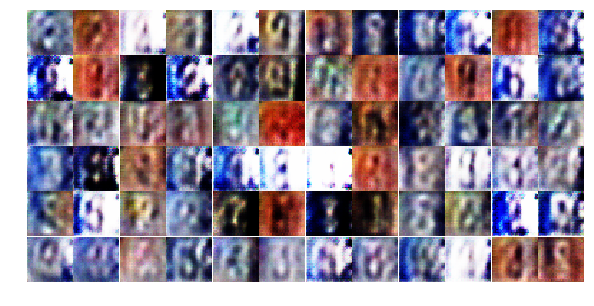

Epoch 2/20... Discriminator Loss: 0.4888... Generator Loss: 2.1494
Epoch 2/20... Discriminator Loss: 0.2015... Generator Loss: 2.4377
Epoch 2/20... Discriminator Loss: 0.2039... Generator Loss: 2.2270
Epoch 2/20... Discriminator Loss: 0.8848... Generator Loss: 0.9511
Epoch 2/20... Discriminator Loss: 0.1714... Generator Loss: 2.6198
Epoch 2/20... Discriminator Loss: 0.0998... Generator Loss: 3.6613
Epoch 2/20... Discriminator Loss: 2.4844... Generator Loss: 0.2179
Epoch 2/20... Discriminator Loss: 0.8593... Generator Loss: 0.8959
Epoch 2/20... Discriminator Loss: 0.5524... Generator Loss: 3.8062
Epoch 2/20... Discriminator Loss: 0.8177... Generator Loss: 0.8648


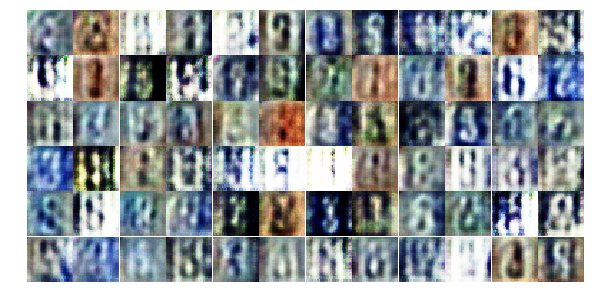

Epoch 2/20... Discriminator Loss: 0.1365... Generator Loss: 4.1511
Epoch 2/20... Discriminator Loss: 0.7907... Generator Loss: 0.9576
Epoch 2/20... Discriminator Loss: 0.3228... Generator Loss: 1.7691
Epoch 2/20... Discriminator Loss: 0.2237... Generator Loss: 2.5508
Epoch 2/20... Discriminator Loss: 0.1615... Generator Loss: 2.4100
Epoch 2/20... Discriminator Loss: 0.0170... Generator Loss: 5.4872
Epoch 2/20... Discriminator Loss: 0.1803... Generator Loss: 4.7329
Epoch 2/20... Discriminator Loss: 4.0154... Generator Loss: 0.0540
Epoch 2/20... Discriminator Loss: 0.9641... Generator Loss: 0.7956
Epoch 2/20... Discriminator Loss: 1.8449... Generator Loss: 0.2562


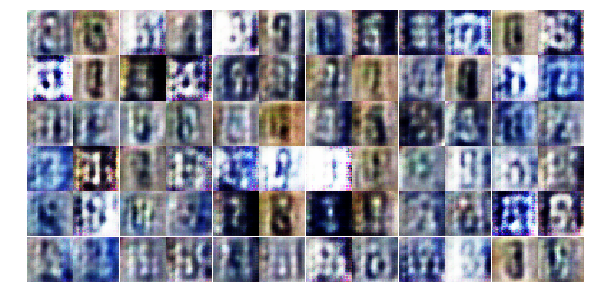

Epoch 2/20... Discriminator Loss: 0.3503... Generator Loss: 2.3710
Epoch 2/20... Discriminator Loss: 0.6027... Generator Loss: 2.2547
Epoch 2/20... Discriminator Loss: 0.1524... Generator Loss: 2.9262
Epoch 2/20... Discriminator Loss: 0.2018... Generator Loss: 4.6393
Epoch 2/20... Discriminator Loss: 0.0860... Generator Loss: 3.7875
Epoch 2/20... Discriminator Loss: 1.8317... Generator Loss: 0.2797
Epoch 2/20... Discriminator Loss: 0.6766... Generator Loss: 1.1044
Epoch 2/20... Discriminator Loss: 0.1110... Generator Loss: 3.8071
Epoch 2/20... Discriminator Loss: 0.1974... Generator Loss: 4.6090
Epoch 2/20... Discriminator Loss: 0.2368... Generator Loss: 2.2261


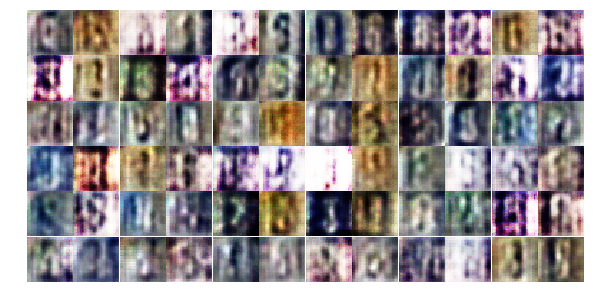

Epoch 2/20... Discriminator Loss: 0.1833... Generator Loss: 2.1497
Epoch 2/20... Discriminator Loss: 0.0432... Generator Loss: 4.0366
Epoch 2/20... Discriminator Loss: 0.1550... Generator Loss: 2.8925
Epoch 2/20... Discriminator Loss: 0.4117... Generator Loss: 1.4202
Epoch 3/20... Discriminator Loss: 0.1047... Generator Loss: 3.1836
Epoch 3/20... Discriminator Loss: 0.2224... Generator Loss: 2.1143
Epoch 3/20... Discriminator Loss: 0.0821... Generator Loss: 3.1060
Epoch 3/20... Discriminator Loss: 0.0881... Generator Loss: 2.9840
Epoch 3/20... Discriminator Loss: 0.1540... Generator Loss: 2.3798
Epoch 3/20... Discriminator Loss: 3.5703... Generator Loss: 0.0611


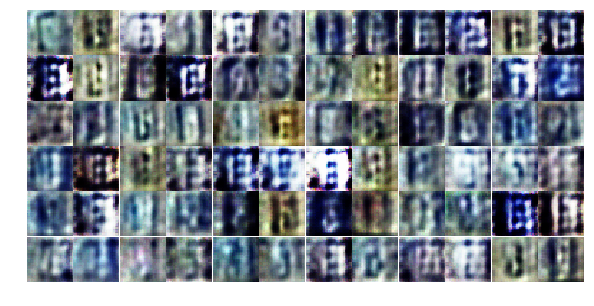

Epoch 3/20... Discriminator Loss: 0.8226... Generator Loss: 1.3882
Epoch 3/20... Discriminator Loss: 0.7625... Generator Loss: 1.4610
Epoch 3/20... Discriminator Loss: 1.0806... Generator Loss: 0.8368
Epoch 3/20... Discriminator Loss: 0.9919... Generator Loss: 0.7443
Epoch 3/20... Discriminator Loss: 1.1656... Generator Loss: 0.5954
Epoch 3/20... Discriminator Loss: 0.2809... Generator Loss: 2.1578
Epoch 3/20... Discriminator Loss: 2.1711... Generator Loss: 4.0831
Epoch 3/20... Discriminator Loss: 0.6690... Generator Loss: 1.3679
Epoch 3/20... Discriminator Loss: 0.5927... Generator Loss: 1.2572
Epoch 3/20... Discriminator Loss: 0.2316... Generator Loss: 2.8119


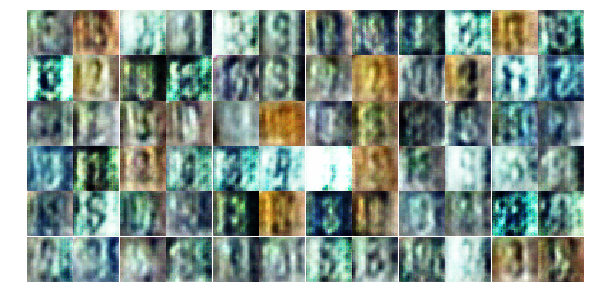

Epoch 3/20... Discriminator Loss: 0.1161... Generator Loss: 3.2884
Epoch 3/20... Discriminator Loss: 0.2393... Generator Loss: 2.5360
Epoch 3/20... Discriminator Loss: 0.1857... Generator Loss: 2.0617
Epoch 3/20... Discriminator Loss: 0.8375... Generator Loss: 1.0263
Epoch 3/20... Discriminator Loss: 0.4541... Generator Loss: 1.9190
Epoch 3/20... Discriminator Loss: 0.5370... Generator Loss: 1.0967
Epoch 3/20... Discriminator Loss: 0.3167... Generator Loss: 2.7359
Epoch 3/20... Discriminator Loss: 0.2595... Generator Loss: 1.9813
Epoch 3/20... Discriminator Loss: 0.0758... Generator Loss: 3.5713
Epoch 3/20... Discriminator Loss: 0.5584... Generator Loss: 1.1375


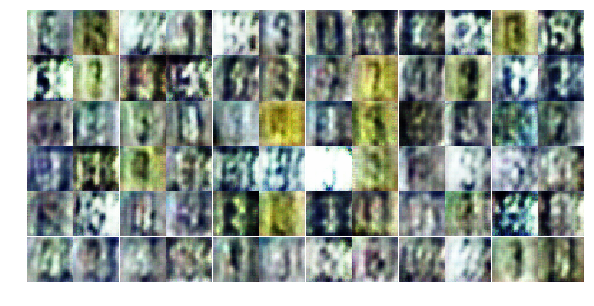

Epoch 3/20... Discriminator Loss: 1.0293... Generator Loss: 0.6614
Epoch 3/20... Discriminator Loss: 0.1296... Generator Loss: 2.9081
Epoch 3/20... Discriminator Loss: 0.0588... Generator Loss: 4.2313
Epoch 3/20... Discriminator Loss: 0.8233... Generator Loss: 0.8836
Epoch 3/20... Discriminator Loss: 1.1883... Generator Loss: 0.4619
Epoch 3/20... Discriminator Loss: 0.1146... Generator Loss: 3.1299
Epoch 3/20... Discriminator Loss: 0.0537... Generator Loss: 4.0401
Epoch 3/20... Discriminator Loss: 0.1237... Generator Loss: 4.2869
Epoch 3/20... Discriminator Loss: 0.0844... Generator Loss: 2.9242
Epoch 3/20... Discriminator Loss: 0.0223... Generator Loss: 5.7625


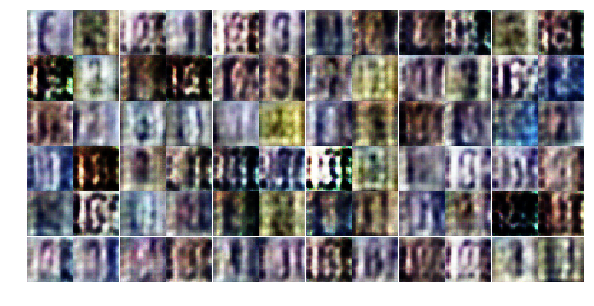

Epoch 3/20... Discriminator Loss: 0.2745... Generator Loss: 1.7673
Epoch 3/20... Discriminator Loss: 0.1826... Generator Loss: 2.9382
Epoch 3/20... Discriminator Loss: 0.0326... Generator Loss: 5.8425
Epoch 3/20... Discriminator Loss: 0.2613... Generator Loss: 2.4427
Epoch 3/20... Discriminator Loss: 0.0154... Generator Loss: 4.7987
Epoch 3/20... Discriminator Loss: 0.0170... Generator Loss: 8.1558
Epoch 3/20... Discriminator Loss: 0.0279... Generator Loss: 5.4842
Epoch 3/20... Discriminator Loss: 0.0605... Generator Loss: 3.9118
Epoch 3/20... Discriminator Loss: 0.0261... Generator Loss: 7.3376
Epoch 3/20... Discriminator Loss: 0.0154... Generator Loss: 7.7928


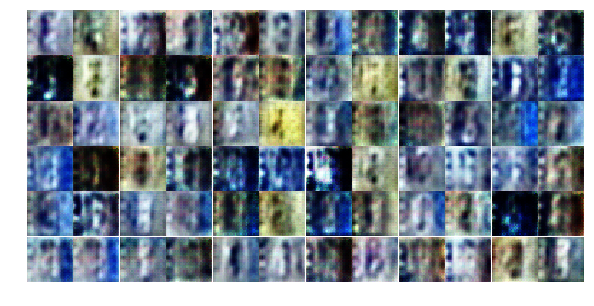

Epoch 3/20... Discriminator Loss: 2.7571... Generator Loss: 0.1294
Epoch 3/20... Discriminator Loss: 0.8908... Generator Loss: 1.2535
Epoch 3/20... Discriminator Loss: 0.8027... Generator Loss: 1.1465
Epoch 3/20... Discriminator Loss: 0.7470... Generator Loss: 1.0481
Epoch 3/20... Discriminator Loss: 1.0633... Generator Loss: 2.2816
Epoch 3/20... Discriminator Loss: 0.9500... Generator Loss: 1.3291
Epoch 3/20... Discriminator Loss: 0.8112... Generator Loss: 1.6985
Epoch 3/20... Discriminator Loss: 1.2111... Generator Loss: 1.3628
Epoch 3/20... Discriminator Loss: 0.9551... Generator Loss: 1.2218
Epoch 3/20... Discriminator Loss: 0.8870... Generator Loss: 1.0558


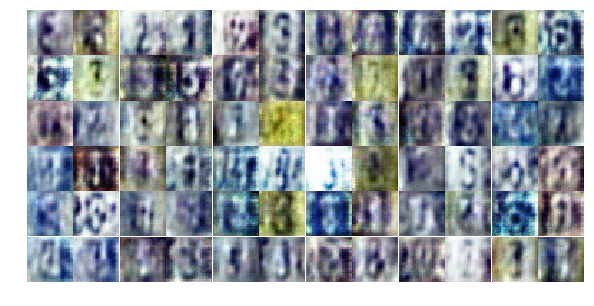

Epoch 3/20... Discriminator Loss: 0.9500... Generator Loss: 0.7786
Epoch 4/20... Discriminator Loss: 1.9994... Generator Loss: 2.3034
Epoch 4/20... Discriminator Loss: 0.7718... Generator Loss: 1.5821
Epoch 4/20... Discriminator Loss: 1.3464... Generator Loss: 0.4495
Epoch 4/20... Discriminator Loss: 0.3768... Generator Loss: 1.6948
Epoch 4/20... Discriminator Loss: 0.9425... Generator Loss: 0.9122
Epoch 4/20... Discriminator Loss: 0.9622... Generator Loss: 0.9873
Epoch 4/20... Discriminator Loss: 0.3835... Generator Loss: 2.0447
Epoch 4/20... Discriminator Loss: 0.4614... Generator Loss: 1.5767
Epoch 4/20... Discriminator Loss: 1.2992... Generator Loss: 0.4163


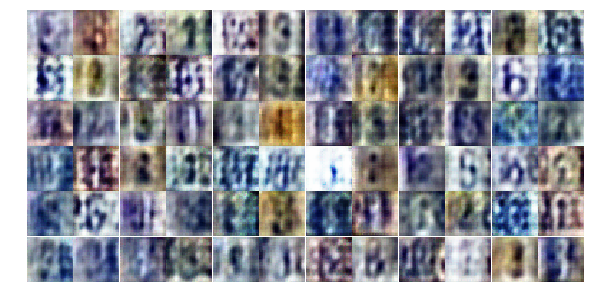

Epoch 4/20... Discriminator Loss: 0.3459... Generator Loss: 1.9086
Epoch 4/20... Discriminator Loss: 0.3301... Generator Loss: 4.6686
Epoch 4/20... Discriminator Loss: 1.1822... Generator Loss: 2.3306
Epoch 4/20... Discriminator Loss: 2.1796... Generator Loss: 0.1873
Epoch 4/20... Discriminator Loss: 0.5029... Generator Loss: 1.3049
Epoch 4/20... Discriminator Loss: 0.6013... Generator Loss: 2.1736
Epoch 4/20... Discriminator Loss: 1.0515... Generator Loss: 0.8051
Epoch 4/20... Discriminator Loss: 0.3085... Generator Loss: 2.4866
Epoch 4/20... Discriminator Loss: 0.4296... Generator Loss: 1.7807
Epoch 4/20... Discriminator Loss: 0.1342... Generator Loss: 3.5994


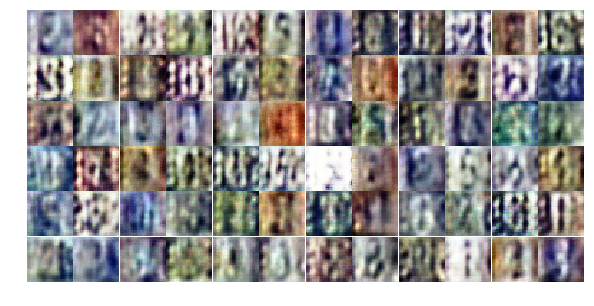

Epoch 4/20... Discriminator Loss: 0.9159... Generator Loss: 2.4452
Epoch 4/20... Discriminator Loss: 0.6131... Generator Loss: 4.2713
Epoch 4/20... Discriminator Loss: 0.4870... Generator Loss: 1.9452
Epoch 4/20... Discriminator Loss: 0.1735... Generator Loss: 2.7918
Epoch 4/20... Discriminator Loss: 1.3181... Generator Loss: 0.4042
Epoch 4/20... Discriminator Loss: 1.1821... Generator Loss: 1.1734
Epoch 4/20... Discriminator Loss: 1.5349... Generator Loss: 0.4883
Epoch 4/20... Discriminator Loss: 0.7483... Generator Loss: 0.9464
Epoch 4/20... Discriminator Loss: 0.3062... Generator Loss: 2.9124
Epoch 4/20... Discriminator Loss: 0.2837... Generator Loss: 4.5433


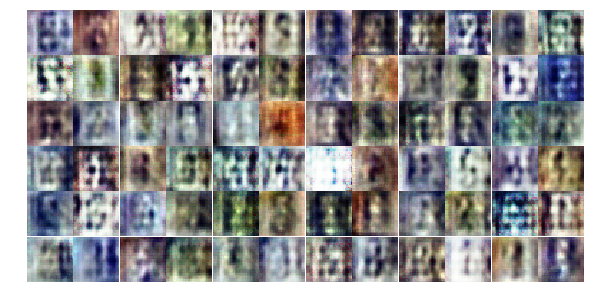

Epoch 4/20... Discriminator Loss: 0.3054... Generator Loss: 1.7894
Epoch 4/20... Discriminator Loss: 0.1679... Generator Loss: 2.7048
Epoch 4/20... Discriminator Loss: 0.4091... Generator Loss: 1.3153
Epoch 4/20... Discriminator Loss: 0.1094... Generator Loss: 3.1547
Epoch 4/20... Discriminator Loss: 0.1692... Generator Loss: 5.2744
Epoch 4/20... Discriminator Loss: 0.2015... Generator Loss: 3.6319
Epoch 4/20... Discriminator Loss: 0.2667... Generator Loss: 2.2804
Epoch 4/20... Discriminator Loss: 0.3078... Generator Loss: 2.6784
Epoch 4/20... Discriminator Loss: 0.3459... Generator Loss: 3.3113
Epoch 4/20... Discriminator Loss: 0.4906... Generator Loss: 1.9409


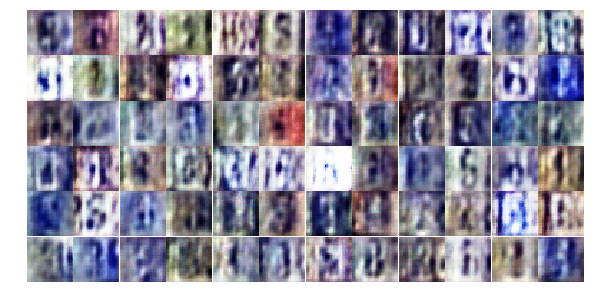

Epoch 4/20... Discriminator Loss: 0.4077... Generator Loss: 2.5938
Epoch 4/20... Discriminator Loss: 0.4886... Generator Loss: 1.1923
Epoch 4/20... Discriminator Loss: 2.5966... Generator Loss: 5.4992
Epoch 4/20... Discriminator Loss: 0.7257... Generator Loss: 0.9791
Epoch 4/20... Discriminator Loss: 0.0724... Generator Loss: 6.2798
Epoch 4/20... Discriminator Loss: 0.0911... Generator Loss: 3.7003
Epoch 4/20... Discriminator Loss: 0.9696... Generator Loss: 0.8406
Epoch 4/20... Discriminator Loss: 0.1511... Generator Loss: 2.6130
Epoch 4/20... Discriminator Loss: 0.0314... Generator Loss: 6.9253
Epoch 4/20... Discriminator Loss: 0.8749... Generator Loss: 0.9894


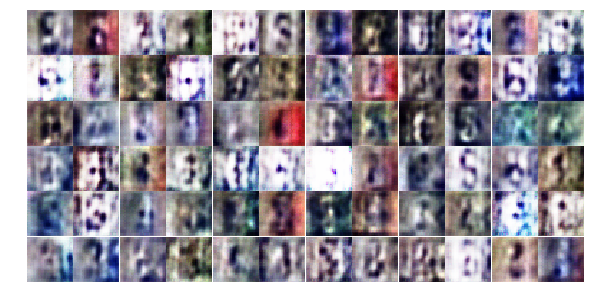

Epoch 4/20... Discriminator Loss: 0.2997... Generator Loss: 2.8745
Epoch 4/20... Discriminator Loss: 0.7765... Generator Loss: 0.8259
Epoch 4/20... Discriminator Loss: 0.7543... Generator Loss: 0.8865
Epoch 4/20... Discriminator Loss: 0.0394... Generator Loss: 6.3195
Epoch 4/20... Discriminator Loss: 0.0444... Generator Loss: 4.7839
Epoch 4/20... Discriminator Loss: 0.9910... Generator Loss: 0.5671
Epoch 4/20... Discriminator Loss: 0.0185... Generator Loss: 5.6650
Epoch 4/20... Discriminator Loss: 0.0240... Generator Loss: 7.4413


In [ ]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))